In [2]:
import numpy as np
import gzip
import pickle
import sys
import copy
import os.path
import pdb
from copy import deepcopy

import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

# Split MNIST

In [5]:
with open('results/split_mnist.pkl', 'rb') as input_file:
    d = pickle.load(input_file)
ibp_acc = d['vcl_ibp']
vcl_result = d['vcl_h10']
vcl_result_h5 = d['vcl_h5']
vcl_result_h50 = d['vcl_h50']

/home/skessler/anaconda2/envs/py36/lib/python3.6/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


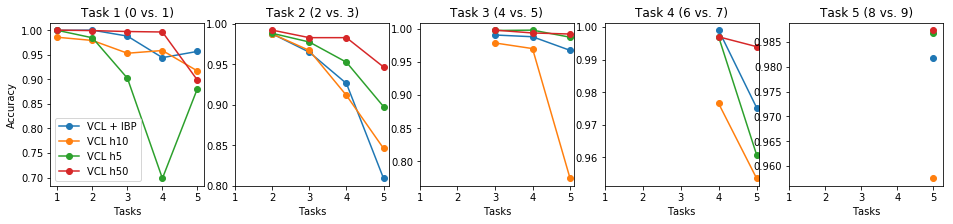

In [12]:
titles = {0: "Task 1 (0 vs. 1)",
          1: "Task 2 (2 vs. 3)",
          2: "Task 3 (4 vs. 5)",
          3: "Task 4 (6 vs. 7)",
          4: "Task 5 (8 vs. 9)"}
no_tasks=5
fig, ax = plt.subplots(1, 5, figsize=(16, 3))
for i in range(no_tasks):
    ax[i].plot(np.arange(len(ibp_acc[:, i]))+1, ibp_acc[:, i], label='VCL + IBP', marker='o')
    ax[i].plot(np.arange(len(vcl_result[:, i]))+1, vcl_result[:, i], label='VCL h10', marker='o')
    ax[i].plot(np.arange(len(vcl_result_h5[:, i]))+1, vcl_result_h5[:, i], label='VCL h5', marker='o')
    ax[i].plot(np.arange(len(vcl_result_h50[:, i]))+1, vcl_result_h50[:, i], label='VCL h50', marker='o')
    ax[i].set_title(titles[i])
    ax[i].set_xticks(range(1, len(vcl_result[:,i])+1))
    ax[i].set_xlabel('Tasks')
    if i == 0:
        ax[i].legend()
        ax[i].set_ylabel('Accuracy')
fig.show()

/home/skessler/anaconda2/envs/py36/lib/python3.6/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


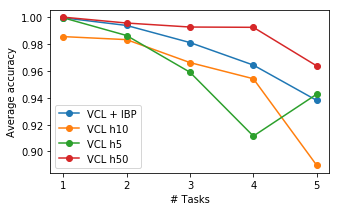

In [15]:
_ibp_acc = np.nanmean(ibp_acc, 1)
_vcl_result = np.nanmean(vcl_result, 1)
_vcl_result_h5 = np.nanmean(vcl_result_h5, 1)
_vcl_result_h50 = np.nanmean(vcl_result_h50, 1)

fig = plt.figure(figsize=(5,3))
ax = plt.gca()
plt.plot(np.arange(len(_ibp_acc))+1, _ibp_acc, label='VCL + IBP', marker='o')
plt.plot(np.arange(len(_vcl_result))+1, _vcl_result, label='VCL h10', marker='o')
plt.plot(np.arange(len(_vcl_result))+1, _vcl_result_h5, label='VCL h5', marker='o')
plt.plot(np.arange(len(_vcl_result))+1, _vcl_result_h50, label='VCL h50', marker='o')
ax.set_xticks(range(1, len(_ibp_acc)+1))
ax.set_ylabel('Average accuracy')
ax.set_xlabel('# Tasks')
ax.legend()
fig.show()

# Not MNIST

In [19]:
with open('results/not_mnist.pkl', 'rb') as input_file:
    d = pickle.load(input_file)
ibp_acc = d['vcl_ibp']
vcl_result = d['vcl_h10']
vcl_result_h5 = d['vcl_h5']
vcl_result_h50 = d['vcl_h50']

/home/skessler/anaconda2/envs/py36/lib/python3.6/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


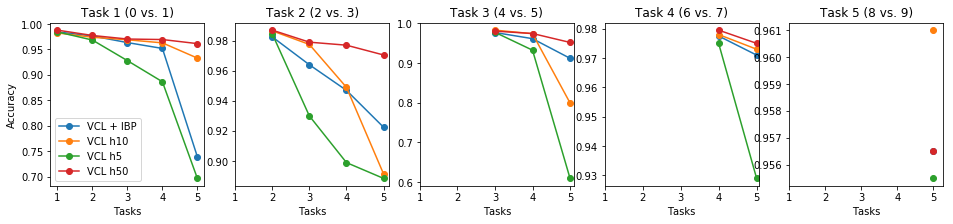

In [20]:
titles = {0: "Task 1 (0 vs. 1)",
          1: "Task 2 (2 vs. 3)",
          2: "Task 3 (4 vs. 5)",
          3: "Task 4 (6 vs. 7)",
          4: "Task 5 (8 vs. 9)"}
no_tasks=5
fig, ax = plt.subplots(1, 5, figsize=(16, 3))
for i in range(no_tasks):
    ax[i].plot(np.arange(len(ibp_acc[:, i]))+1, ibp_acc[:, i], label='VCL + IBP', marker='o')
    ax[i].plot(np.arange(len(vcl_result[:, i]))+1, vcl_result[:, i], label='VCL h10', marker='o')
    ax[i].plot(np.arange(len(vcl_result_h5[:, i]))+1, vcl_result_h5[:, i], label='VCL h5', marker='o')
    ax[i].plot(np.arange(len(vcl_result_h50[:, i]))+1, vcl_result_h50[:, i], label='VCL h50', marker='o')
    ax[i].set_title(titles[i])
    ax[i].set_xticks(range(1, len(vcl_result[:,i])+1))
    ax[i].set_xlabel('Tasks')
    if i == 0:
        ax[i].legend()
        ax[i].set_ylabel('Accuracy')
fig.show()

/home/skessler/anaconda2/envs/py36/lib/python3.6/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


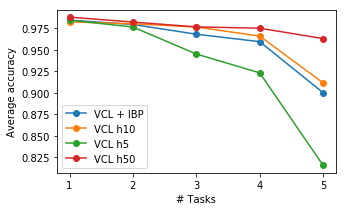

In [21]:
_ibp_acc = np.nanmean(ibp_acc, 1)
_vcl_result = np.nanmean(vcl_result, 1)
_vcl_result_h5 = np.nanmean(vcl_result_h5, 1)
_vcl_result_h50 = np.nanmean(vcl_result_h50, 1)

fig = plt.figure(figsize=(5,3))
ax = plt.gca()
plt.plot(np.arange(len(_ibp_acc))+1, _ibp_acc, label='VCL + IBP', marker='o')
plt.plot(np.arange(len(_vcl_result))+1, _vcl_result, label='VCL h10', marker='o')
plt.plot(np.arange(len(_vcl_result))+1, _vcl_result_h5, label='VCL h5', marker='o')
plt.plot(np.arange(len(_vcl_result))+1, _vcl_result_h50, label='VCL h50', marker='o')
ax.set_xticks(range(1, len(_ibp_acc)+1))
ax.set_ylabel('Average accuracy')
ax.set_xlabel('# Tasks')
ax.legend()
fig.show()

# Split results av and BO opt params

In [57]:
with open('ddm/results/split_mnist_res5_vanilla.pkl', 'rb') as input_file:
    d = pickle.load(input_file)
ibp_acc = d['vcl_ibp']
vcl_result = d['vcl_h10']
vcl_result_h5 = d['vcl_h5']
vcl_result_h50 = d['vcl_h50']

In [58]:
with open('results/split_mnist_res5_opt_params.pkl', 'rb') as input_file:
    d = pickle.load(input_file)
ibp_acc_opt = d['vcl_ibp']
vcl_result_opt = d['vcl_h10']
vcl_result_h5_opt = d['vcl_h5']
vcl_result_h50_opt = d['vcl_h50']

In [59]:
_ibp_acc = np.mean(ibp_acc, 0)
_vcl_result = np.mean(vcl_result, 0)
_vcl_result_h5 = np.mean(vcl_result_h5, 0)
_vcl_result_h50 = np.mean(vcl_result_h50, 0)
_ibp_acc_opt = np.mean(ibp_acc_opt, 0)
_vcl_result_opt = np.mean(vcl_result_opt, 0)
_vcl_result_h5_opt = np.mean(vcl_result_h5_opt, 0)
_vcl_result_h50_opt = np.mean(vcl_result_h50_opt, 0)

/Users/samuelKessler/anaconda3/envs/py36/lib/python3.6/site-packages/matplotlib/figure.py:448: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


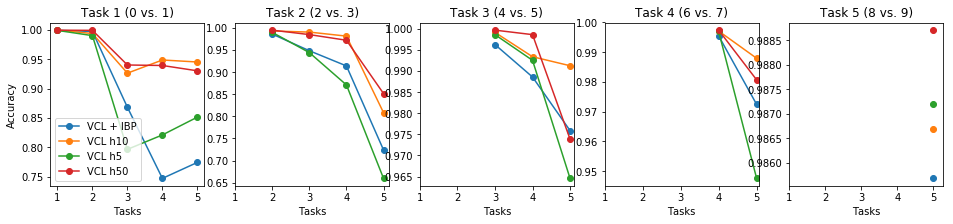

In [60]:
titles = {0: "Task 1 (0 vs. 1)",
          1: "Task 2 (2 vs. 3)",
          2: "Task 3 (4 vs. 5)",
          3: "Task 4 (6 vs. 7)",
          4: "Task 5 (8 vs. 9)"}
no_tasks=5
fig, ax = plt.subplots(1, 5, figsize=(16, 3))
for i in range(no_tasks):
    ax[i].plot(np.arange(len(ibp_acc[:, i]))+1, _ibp_acc[:, i], label='VCL + IBP', marker='o')
    ax[i].plot(np.arange(len(vcl_result[:, i]))+1, _vcl_result[:, i], label='VCL h10', marker='o')
    ax[i].plot(np.arange(len(vcl_result_h5[:, i]))+1, _vcl_result_h5[:, i], label='VCL h5', marker='o')
    ax[i].plot(np.arange(len(vcl_result_h50[:, i]))+1, _vcl_result_h50[:, i], label='VCL h50', marker='o')
    ax[i].set_title(titles[i])
    ax[i].set_xticks(range(1, len(vcl_result[:,i])+1))
    ax[i].set_xlabel('Tasks')
    if i == 0:
        ax[i].legend()
        ax[i].set_ylabel('Accuracy')
fig.show()

/Users/samuelKessler/anaconda3/envs/py36/lib/python3.6/site-packages/matplotlib/figure.py:448: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


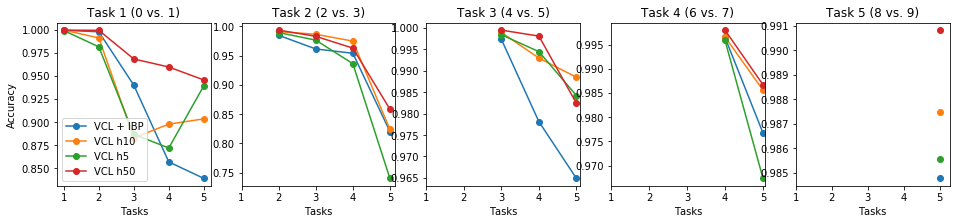

In [62]:
titles = {0: "Task 1 (0 vs. 1)",
          1: "Task 2 (2 vs. 3)",
          2: "Task 3 (4 vs. 5)",
          3: "Task 4 (6 vs. 7)",
          4: "Task 5 (8 vs. 9)"}
no_tasks=5
fig, ax = plt.subplots(1, 5, figsize=(16, 3))
for i in range(no_tasks):
    ax[i].plot(np.arange(len(ibp_acc[:, i]))+1, _ibp_acc_opt[:, i], label='VCL + IBP', marker='o')
    ax[i].plot(np.arange(len(vcl_result[:, i]))+1, _vcl_result_opt[:, i], label='VCL h10', marker='o')
    ax[i].plot(np.arange(len(vcl_result_h5[:, i]))+1, _vcl_result_h5_opt[:, i], label='VCL h5', marker='o')
    ax[i].plot(np.arange(len(vcl_result_h50[:, i]))+1, _vcl_result_h50_opt[:, i], label='VCL h50', marker='o')
    ax[i].set_title(titles[i])
    ax[i].set_xticks(range(1, len(vcl_result[:,i])+1))
    ax[i].set_xlabel('Tasks')
    if i == 0:
        ax[i].legend()
        ax[i].set_ylabel('Accuracy')
fig.show()

/Users/samuelKessler/anaconda3/envs/py36/lib/python3.6/site-packages/matplotlib/figure.py:448: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


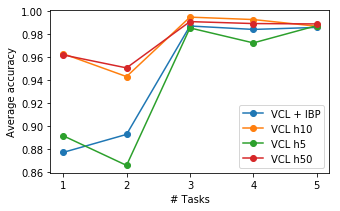

In [34]:
_ibp_acc = np.nanmean(ibp_acc, (0,1))
_vcl_result = np.nanmean(vcl_result, (0,1))
_vcl_result_h5 = np.nanmean(vcl_result_h5, (0,1))
_vcl_result_h50 = np.nanmean(vcl_result_h50, (0,1))

fig = plt.figure(figsize=(5,3))
ax = plt.gca()
plt.plot(np.arange(len(_ibp_acc))+1, _ibp_acc, label='VCL + IBP', marker='o')
plt.plot(np.arange(len(_vcl_result))+1, _vcl_result, label='VCL h10', marker='o')
plt.plot(np.arange(len(_vcl_result))+1, _vcl_result_h5, label='VCL h5', marker='o')
plt.plot(np.arange(len(_vcl_result))+1, _vcl_result_h50, label='VCL h50', marker='o')
ax.set_xticks(range(1, len(_ibp_acc)+1))
ax.set_ylabel('Average accuracy')
ax.set_xlabel('# Tasks')
ax.legend()
fig.show()

/Users/samuelKessler/anaconda3/envs/py36/lib/python3.6/site-packages/matplotlib/figure.py:448: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


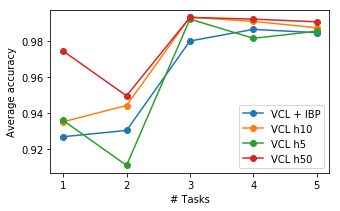

In [63]:
_ibp_acc_opt = np.nanmean(ibp_acc_opt, (0,1))
_vcl_result_opt = np.nanmean(vcl_result_opt, (0,1))
_vcl_result_h5_opt = np.nanmean(vcl_result_h5_opt, (0,1))
_vcl_result_h50_opt = np.nanmean(vcl_result_h50_opt, (0,1))

fig = plt.figure(figsize=(5,3))
ax = plt.gca()
plt.plot(np.arange(len(_ibp_acc))+1, _ibp_acc_opt, label='VCL + IBP', marker='o')
plt.plot(np.arange(len(_vcl_result))+1, _vcl_result_opt, label='VCL h10', marker='o')
plt.plot(np.arange(len(_vcl_result))+1, _vcl_result_h5_opt, label='VCL h5', marker='o')
plt.plot(np.arange(len(_vcl_result))+1, _vcl_result_h50_opt, label='VCL h50', marker='o')
ax.set_xticks(range(1, len(_ibp_acc)+1))
ax.set_ylabel('Average accuracy')
ax.set_xlabel('# Tasks')
ax.legend()
fig.show()

# Beta trick split MNIST

In [36]:
with open('results/res_beta_trick_split.pkl', 'rb') as input_file:
    d = pickle.load(input_file)
ibp_acc = d['vcl_ibp']
vcl_result = d['vcl_h10']
vcl_result_h5 = d['vcl_h5']
vcl_result_h50 = d['vcl_h50']

In [37]:
ibp_acc.shape

(5, 5)

/Users/samuelKessler/anaconda3/envs/py36/lib/python3.6/site-packages/matplotlib/figure.py:448: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


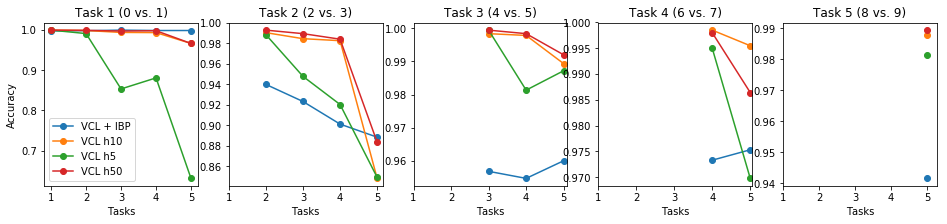

In [39]:
titles = {0: "Task 1 (0 vs. 1)",
          1: "Task 2 (2 vs. 3)",
          2: "Task 3 (4 vs. 5)",
          3: "Task 4 (6 vs. 7)",
          4: "Task 5 (8 vs. 9)"}
no_tasks=5
fig, ax = plt.subplots(1, 5, figsize=(16, 3))
for i in range(no_tasks):
    ax[i].plot(np.arange(len(ibp_acc[:, i]))+1, ibp_acc[:, i], label='VCL + IBP', marker='o')
    ax[i].plot(np.arange(len(vcl_result[:, i]))+1, vcl_result[:, i], label='VCL h10', marker='o')
    ax[i].plot(np.arange(len(vcl_result_h5[:, i]))+1, vcl_result_h5[:, i], label='VCL h5', marker='o')
    ax[i].plot(np.arange(len(vcl_result_h50[:, i]))+1, vcl_result_h50[:, i], label='VCL h50', marker='o')
    ax[i].set_title(titles[i])
    ax[i].set_xticks(range(1, len(vcl_result[:,i])+1))
    ax[i].set_xlabel('Tasks')
    if i == 0:
        ax[i].legend()
        ax[i].set_ylabel('Accuracy')
fig.show()

/Users/samuelKessler/anaconda3/envs/py36/lib/python3.6/site-packages/matplotlib/figure.py:448: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


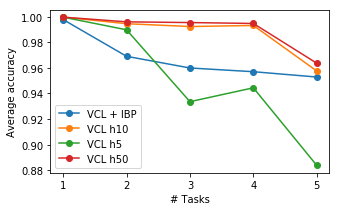

In [40]:
_ibp_acc = np.nanmean(ibp_acc, 1)
_vcl_result = np.nanmean(vcl_result, 1)
_vcl_result_h5 = np.nanmean(vcl_result_h5, 1)
_vcl_result_h50 = np.nanmean(vcl_result_h50, 1)

fig = plt.figure(figsize=(5,3))
ax = plt.gca()
plt.plot(np.arange(len(_ibp_acc))+1, _ibp_acc, label='VCL + IBP', marker='o')
plt.plot(np.arange(len(_vcl_result))+1, _vcl_result, label='VCL h10', marker='o')
plt.plot(np.arange(len(_vcl_result))+1, _vcl_result_h5, label='VCL h5', marker='o')
plt.plot(np.arange(len(_vcl_result))+1, _vcl_result_h50, label='VCL h50', marker='o')
ax.set_xticks(range(1, len(_ibp_acc)+1))
ax.set_ylabel('Average accuracy')
ax.set_xlabel('# Tasks')
ax.legend()
fig.show()

# Not results av and opt params

In [65]:
with open('ddm/results/split_not_mnist_res5.pkl', 'rb') as input_file:
    d = pickle.load(input_file)
d.keys()

dict_keys(['vcl_ibp', 'vcl_h10', 'vcl_h5', 'vcl_h50'])

In [67]:
with open('results/split_not_mnist_res5_opt_params.pkl', 'rb') as input_file:
    d_opt = pickle.load(input_file)
d_opt.keys()

dict_keys(['vcl_ibp', 'vcl_h10', 'vcl_h5', 'vcl_h50'])

In [68]:
ibp_acc = d['vcl_ibp'] # 5, 5, 5
vcl_result = d['vcl_h10']
vcl_result_h5 = d['vcl_h5']
vcl_result_h50 = d['vcl_h50']
ibp_acc_opt = d_opt['vcl_ibp'] # 5, 5, 5
vcl_result_opt = d_opt['vcl_h10']
vcl_result_h5_opt = d_opt['vcl_h5']
vcl_result_h50_opt = d_opt['vcl_h50']
_ibp_acc = np.mean(ibp_acc, 0)
_vcl_result = np.mean(vcl_result, 0)
_vcl_result_h5 = np.mean(vcl_result_h5, 0)
_vcl_result_h50 = np.mean(vcl_result_h50, 0)
_ibp_acc_opt = np.mean(ibp_acc_opt, 0)
_vcl_result_opt = np.mean(vcl_result_opt, 0)
_vcl_result_h5_opt = np.mean(vcl_result_h5_opt, 0)
_vcl_result_h50_opt = np.mean(vcl_result_h50_opt, 0)

/Users/samuelKessler/anaconda3/envs/py36/lib/python3.6/site-packages/matplotlib/figure.py:448: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


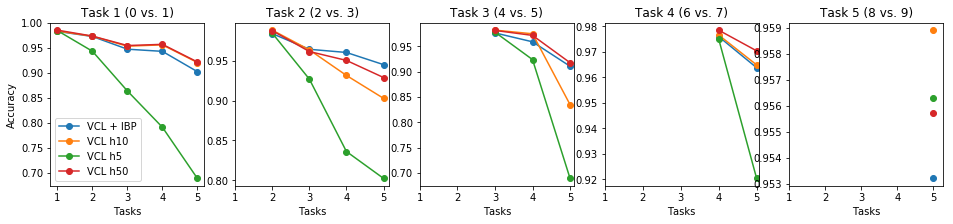

In [69]:
titles = {0: "Task 1 (0 vs. 1)",
          1: "Task 2 (2 vs. 3)",
          2: "Task 3 (4 vs. 5)",
          3: "Task 4 (6 vs. 7)",
          4: "Task 5 (8 vs. 9)"}
no_tasks=5
fig, ax = plt.subplots(1, 5, figsize=(16, 3))
for i in range(no_tasks):
    ax[i].plot(np.arange(len(ibp_acc[:, i]))+1, _ibp_acc[:, i], label='VCL + IBP', marker='o')
    ax[i].plot(np.arange(len(vcl_result[:, i]))+1, _vcl_result[:, i], label='VCL h10', marker='o')
    ax[i].plot(np.arange(len(vcl_result_h5[:, i]))+1, _vcl_result_h5[:, i], label='VCL h5', marker='o')
    ax[i].plot(np.arange(len(vcl_result_h50[:, i]))+1, _vcl_result_h50[:, i], label='VCL h50', marker='o')
    ax[i].set_title(titles[i])
    ax[i].set_xticks(range(1, len(vcl_result[:,i])+1))
    ax[i].set_xlabel('Tasks')
    if i == 0:
        ax[i].legend()
        ax[i].set_ylabel('Accuracy')
fig.show()

/Users/samuelKessler/anaconda3/envs/py36/lib/python3.6/site-packages/matplotlib/figure.py:448: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


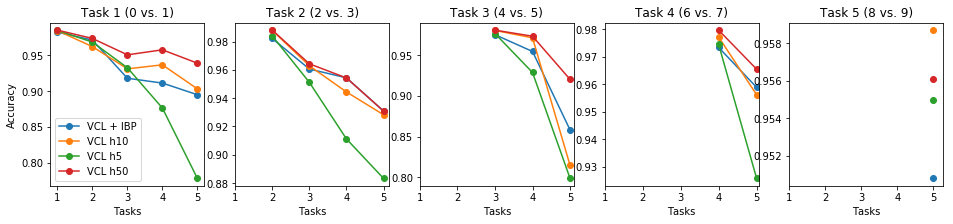

In [70]:
titles = {0: "Task 1 (0 vs. 1)",
          1: "Task 2 (2 vs. 3)",
          2: "Task 3 (4 vs. 5)",
          3: "Task 4 (6 vs. 7)",
          4: "Task 5 (8 vs. 9)"}
no_tasks=5
fig, ax = plt.subplots(1, 5, figsize=(16, 3))
for i in range(no_tasks):
    ax[i].plot(np.arange(len(ibp_acc[:, i]))+1, _ibp_acc_opt[:, i], label='VCL + IBP', marker='o')
    ax[i].plot(np.arange(len(vcl_result[:, i]))+1, _vcl_result_opt[:, i], label='VCL h10', marker='o')
    ax[i].plot(np.arange(len(vcl_result_h5[:, i]))+1, _vcl_result_h5_opt[:, i], label='VCL h5', marker='o')
    ax[i].plot(np.arange(len(vcl_result_h50[:, i]))+1, _vcl_result_h50_opt[:, i], label='VCL h50', marker='o')
    ax[i].set_title(titles[i])
    ax[i].set_xticks(range(1, len(vcl_result[:,i])+1))
    ax[i].set_xlabel('Tasks')
    if i == 0:
        ax[i].legend()
        ax[i].set_ylabel('Accuracy')
fig.show()

/Users/samuelKessler/anaconda3/envs/py36/lib/python3.6/site-packages/matplotlib/figure.py:448: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


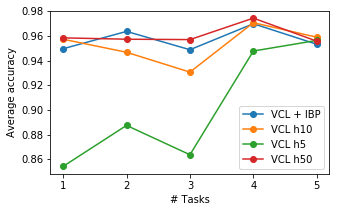

In [71]:
_ibp_acc = np.nanmean(ibp_acc, (0,1))
_vcl_result = np.nanmean(vcl_result, (0,1))
_vcl_result_h5 = np.nanmean(vcl_result_h5, (0,1))
_vcl_result_h50 = np.nanmean(vcl_result_h50, (0,1))

fig = plt.figure(figsize=(5,3))
ax = plt.gca()
plt.plot(np.arange(len(_ibp_acc))+1, _ibp_acc, label='VCL + IBP', marker='o')
plt.plot(np.arange(len(_vcl_result))+1, _vcl_result, label='VCL h10', marker='o')
plt.plot(np.arange(len(_vcl_result))+1, _vcl_result_h5, label='VCL h5', marker='o')
plt.plot(np.arange(len(_vcl_result))+1, _vcl_result_h50, label='VCL h50', marker='o')
ax.set_xticks(range(1, len(_ibp_acc)+1))
ax.set_ylabel('Average accuracy')
ax.set_xlabel('# Tasks')
ax.legend()
fig.show()

/Users/samuelKessler/anaconda3/envs/py36/lib/python3.6/site-packages/matplotlib/figure.py:448: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


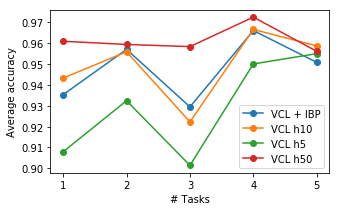

In [72]:
_ibp_acc_opt = np.nanmean(ibp_acc_opt, (0,1))
_vcl_result_opt = np.nanmean(vcl_result_opt, (0,1))
_vcl_result_h5_opt = np.nanmean(vcl_result_h5_opt, (0,1))
_vcl_result_h50_opt = np.nanmean(vcl_result_h50_opt, (0,1))

fig = plt.figure(figsize=(5,3))
ax = plt.gca()
plt.plot(np.arange(len(_ibp_acc))+1, _ibp_acc_opt, label='VCL + IBP', marker='o')
plt.plot(np.arange(len(_vcl_result))+1, _vcl_result_opt, label='VCL h10', marker='o')
plt.plot(np.arange(len(_vcl_result))+1, _vcl_result_h5_opt, label='VCL h5', marker='o')
plt.plot(np.arange(len(_vcl_result))+1, _vcl_result_h50_opt, label='VCL h50', marker='o')
ax.set_xticks(range(1, len(_ibp_acc)+1))
ax.set_ylabel('Average accuracy')
ax.set_xlabel('# Tasks')
ax.legend()
fig.show()

# Difficult split MNIST 5 runs and opt params

In [43]:
with open('ddm/results/split_mnist_res5_difficult.pkl', 'rb') as input_file:
    d = pickle.load(input_file)
d.keys()

dict_keys(['vcl_ibp', 'vcl_h10', 'vcl_h5', 'vcl_h50'])

In [48]:
with open('results/split_mnist_res5_difficult_opt_params.pkl', 'rb') as input_file:
    d_opt = pickle.load(input_file)
d.keys()

dict_keys(['vcl_ibp', 'vcl_h10', 'vcl_h5', 'vcl_h50'])

In [49]:
ibp_acc = d['vcl_ibp'] # 5, 5, 5
vcl_result = d['vcl_h10']
vcl_result_h5 = d['vcl_h5']
vcl_result_h50 = d['vcl_h50']
ibp_acc_opt = d_opt['vcl_ibp'] # 5, 5, 5
vcl_result_opt = d_opt['vcl_h10']
vcl_result_h5_opt = d_opt['vcl_h5']
vcl_result_h50_opt = d_opt['vcl_h50']
_ibp_acc = np.mean(ibp_acc, 0)
_vcl_result = np.mean(vcl_result, 0)
_vcl_result_h5 = np.mean(vcl_result_h5, 0)
_vcl_result_h50 = np.mean(vcl_result_h50, 0)
_ibp_acc_opt = np.mean(ibp_acc_opt, 0)
_vcl_result_opt = np.mean(vcl_result_opt, 0)
_vcl_result_h5_opt = np.mean(vcl_result_h5_opt, 0)
_vcl_result_h50_opt = np.mean(vcl_result_h50_opt, 0)

/Users/samuelKessler/anaconda3/envs/py36/lib/python3.6/site-packages/matplotlib/figure.py:448: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


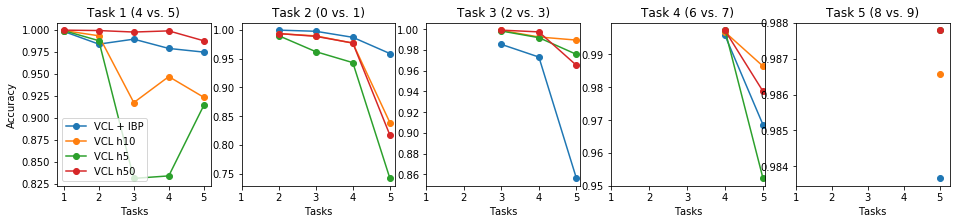

In [50]:
titles = {0: "Task 1 (4 vs. 5)",
          1: "Task 2 (0 vs. 1)",
          2: "Task 3 (2 vs. 3)",
          3: "Task 4 (6 vs. 7)",
          4: "Task 5 (8 vs. 9)"}
no_tasks=5
fig, ax = plt.subplots(1, 5, figsize=(16, 3))
for i in range(no_tasks):
    ax[i].plot(np.arange(len(ibp_acc[:, i]))+1, _ibp_acc[:, i], label='VCL + IBP', marker='o')
    ax[i].plot(np.arange(len(vcl_result[:, i]))+1, _vcl_result[:, i], label='VCL h10', marker='o')
    ax[i].plot(np.arange(len(vcl_result_h5[:, i]))+1, _vcl_result_h5[:, i], label='VCL h5', marker='o')
    ax[i].plot(np.arange(len(vcl_result_h50[:, i]))+1, _vcl_result_h50[:, i], label='VCL h50', marker='o')
    ax[i].set_title(titles[i])
    ax[i].set_xticks(range(1, len(vcl_result[:,i])+1))
    ax[i].set_xlabel('Tasks')
    if i == 0:
        ax[i].legend()
        ax[i].set_ylabel('Accuracy')
fig.show()

/Users/samuelKessler/anaconda3/envs/py36/lib/python3.6/site-packages/matplotlib/figure.py:448: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


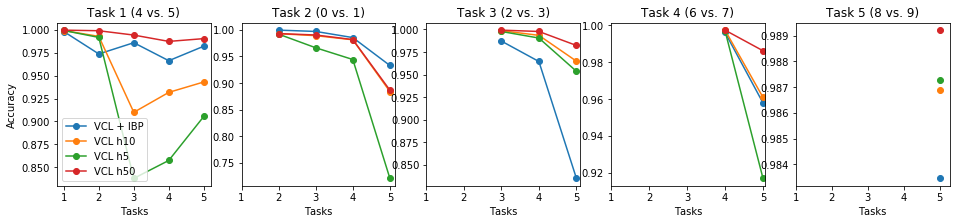

In [51]:
titles = {0: "Task 1 (4 vs. 5)",
          1: "Task 2 (0 vs. 1)",
          2: "Task 3 (2 vs. 3)",
          3: "Task 4 (6 vs. 7)",
          4: "Task 5 (8 vs. 9)"}
no_tasks=5
fig, ax = plt.subplots(1, 5, figsize=(16, 3))
for i in range(no_tasks):
    ax[i].plot(np.arange(len(ibp_acc[:, i]))+1, _ibp_acc_opt[:, i], label='VCL + IBP', marker='o')
    ax[i].plot(np.arange(len(vcl_result[:, i]))+1, _vcl_result_opt[:, i], label='VCL h10', marker='o')
    ax[i].plot(np.arange(len(vcl_result_h5[:, i]))+1, _vcl_result_h5_opt[:, i], label='VCL h5', marker='o')
    ax[i].plot(np.arange(len(vcl_result_h50[:, i]))+1, _vcl_result_h50_opt[:, i], label='VCL h50', marker='o')
    ax[i].set_title(titles[i])
    ax[i].set_xticks(range(1, len(vcl_result[:,i])+1))
    ax[i].set_xlabel('Tasks')
    if i == 0:
        ax[i].legend()
        ax[i].set_ylabel('Accuracy')
fig.show()

/Users/samuelKessler/anaconda3/envs/py36/lib/python3.6/site-packages/matplotlib/figure.py:448: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


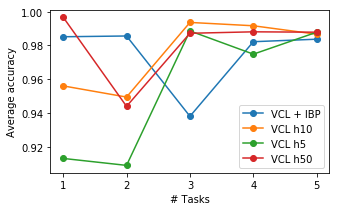

In [52]:
_ibp_acc = np.nanmean(ibp_acc, (0,1))
_vcl_result = np.nanmean(vcl_result, (0,1))
_vcl_result_h5 = np.nanmean(vcl_result_h5, (0,1))
_vcl_result_h50 = np.nanmean(vcl_result_h50, (0,1))

fig = plt.figure(figsize=(5,3))
ax = plt.gca()
plt.plot(np.arange(len(_ibp_acc))+1, _ibp_acc, label='VCL + IBP', marker='o')
plt.plot(np.arange(len(_vcl_result))+1, _vcl_result, label='VCL h10', marker='o')
plt.plot(np.arange(len(_vcl_result))+1, _vcl_result_h5, label='VCL h5', marker='o')
plt.plot(np.arange(len(_vcl_result))+1, _vcl_result_h50, label='VCL h50', marker='o')
ax.set_xticks(range(1, len(_ibp_acc)+1))
ax.set_ylabel('Average accuracy')
ax.set_xlabel('# Tasks')
ax.legend()
fig.show()

/Users/samuelKessler/anaconda3/envs/py36/lib/python3.6/site-packages/matplotlib/figure.py:448: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


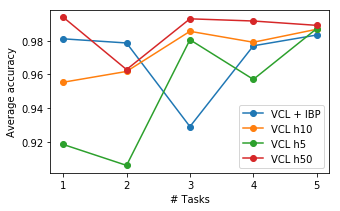

In [53]:
_ibp_acc_opt = np.nanmean(ibp_acc_opt, (0,1))
_vcl_result_opt = np.nanmean(vcl_result_opt, (0,1))
_vcl_result_h5_opt = np.nanmean(vcl_result_h5_opt, (0,1))
_vcl_result_h50_opt = np.nanmean(vcl_result_h50_opt, (0,1))

fig = plt.figure(figsize=(5,3))
ax = plt.gca()
plt.plot(np.arange(len(_ibp_acc))+1, _ibp_acc_opt, label='VCL + IBP', marker='o')
plt.plot(np.arange(len(_vcl_result))+1, _vcl_result_opt, label='VCL h10', marker='o')
plt.plot(np.arange(len(_vcl_result))+1, _vcl_result_h5_opt, label='VCL h5', marker='o')
plt.plot(np.arange(len(_vcl_result))+1, _vcl_result_h50_opt, label='VCL h50', marker='o')
ax.set_xticks(range(1, len(_ibp_acc)+1))
ax.set_ylabel('Average accuracy')
ax.set_xlabel('# Tasks')
ax.legend()
fig.show()

# New results Normal MNIST

In [78]:
with open('ddm/results/split_mnist_res5_split_normal.pkl', 'rb') as input_file:
    d = pickle.load(input_file)
d.keys()

dict_keys(['vcl_ibp', 'vcl_h10', 'vcl_h5', 'vcl_h50'])

In [79]:
ibp_acc = d['vcl_ibp'] # 5, 5, 5
vcl_result = d['vcl_h10']
vcl_result_h5 = d['vcl_h5']
vcl_result_h50 = d['vcl_h50']
_ibp_acc = np.mean(ibp_acc, 0)
_vcl_result = np.mean(vcl_result, 0)
_vcl_result_h5 = np.mean(vcl_result_h5, 0)
_vcl_result_h50 = np.mean(vcl_result_h50, 0)

/Users/samuelKessler/anaconda3/envs/py36/lib/python3.6/site-packages/matplotlib/figure.py:448: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


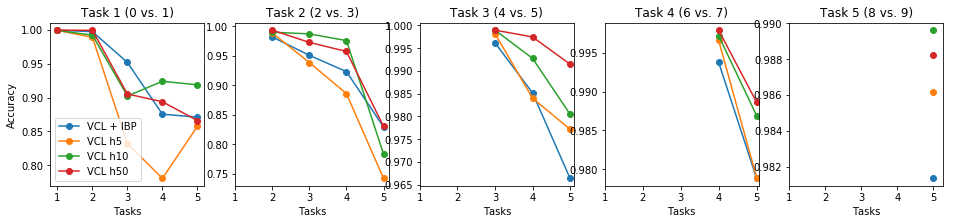

In [80]:
titles = {0: "Task 1 (0 vs. 1)",
          1: "Task 2 (2 vs. 3)",
          2: "Task 3 (4 vs. 5)",
          3: "Task 4 (6 vs. 7)",
          4: "Task 5 (8 vs. 9)"}
no_tasks=5
fig, ax = plt.subplots(1, 5, figsize=(16, 3))
for i in range(no_tasks):
    ax[i].plot(np.arange(len(ibp_acc[:, i]))+1, _ibp_acc[:, i], label='VCL + IBP', marker='o')
    ax[i].plot(np.arange(len(vcl_result_h5[:, i]))+1, _vcl_result_h5[:, i], label='VCL h5', marker='o')
    ax[i].plot(np.arange(len(vcl_result[:, i]))+1, _vcl_result[:, i], label='VCL h10', marker='o')
    ax[i].plot(np.arange(len(vcl_result_h50[:, i]))+1, _vcl_result_h50[:, i], label='VCL h50', marker='o')
    ax[i].set_title(titles[i])
    ax[i].set_xticks(range(1, len(vcl_result[:,i])+1))
    ax[i].set_xlabel('Tasks')
    if i == 0:
        ax[i].legend()
        ax[i].set_ylabel('Accuracy')
fig.show()

/Users/samuelKessler/anaconda3/envs/py36/lib/python3.6/site-packages/matplotlib/figure.py:448: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


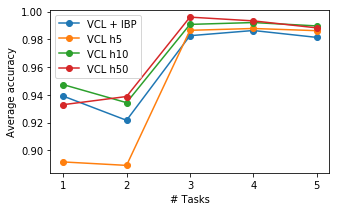

In [82]:
_ibp_acc = np.nanmean(ibp_acc, (0,1))
_vcl_result = np.nanmean(vcl_result, (0,1))
_vcl_result_h5 = np.nanmean(vcl_result_h5, (0,1))
_vcl_result_h50 = np.nanmean(vcl_result_h50, (0,1))

fig = plt.figure(figsize=(5,3))
ax = plt.gca()
plt.plot(np.arange(len(_ibp_acc))+1, _ibp_acc, label='VCL + IBP', marker='o')
plt.plot(np.arange(len(_vcl_result))+1, _vcl_result_h5, label='VCL h5', marker='o')
plt.plot(np.arange(len(_vcl_result))+1, _vcl_result, label='VCL h10', marker='o')
plt.plot(np.arange(len(_vcl_result))+1, _vcl_result_h50, label='VCL h50', marker='o')
ax.set_xticks(range(1, len(_ibp_acc)+1))
ax.set_ylabel('Average accuracy')
ax.set_xlabel('# Tasks')
ax.legend()
fig.show()

# Random background noise MNIST

In [86]:
with open('ddm/results/split_mnist_res5_split_random.pkl', 'rb') as input_file:
    d = pickle.load(input_file)
d.keys()

dict_keys(['vcl_ibp', 'vcl_h10', 'vcl_h5', 'vcl_h50'])

In [87]:
ibp_acc = d['vcl_ibp'] # 5, 5, 5
vcl_result = d['vcl_h10']
vcl_result_h5 = d['vcl_h5']
vcl_result_h50 = d['vcl_h50']
_ibp_acc = np.mean(ibp_acc, 0)
_vcl_result = np.mean(vcl_result, 0)
_vcl_result_h5 = np.mean(vcl_result_h5, 0)
_vcl_result_h50 = np.mean(vcl_result_h50, 0)

/Users/samuelKessler/anaconda3/envs/py36/lib/python3.6/site-packages/matplotlib/figure.py:448: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


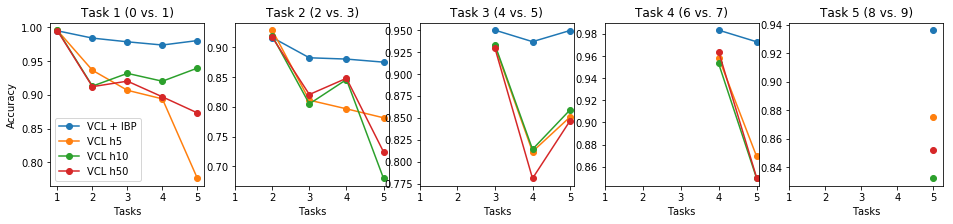

In [88]:
titles = {0: "Task 1 (0 vs. 1)",
          1: "Task 2 (2 vs. 3)",
          2: "Task 3 (4 vs. 5)",
          3: "Task 4 (6 vs. 7)",
          4: "Task 5 (8 vs. 9)"}
no_tasks=5
fig, ax = plt.subplots(1, 5, figsize=(16, 3))
for i in range(no_tasks):
    ax[i].plot(np.arange(len(ibp_acc[:, i]))+1, _ibp_acc[:, i], label='VCL + IBP', marker='o')
    ax[i].plot(np.arange(len(vcl_result_h5[:, i]))+1, _vcl_result_h5[:, i], label='VCL h5', marker='o')
    ax[i].plot(np.arange(len(vcl_result[:, i]))+1, _vcl_result[:, i], label='VCL h10', marker='o')
    ax[i].plot(np.arange(len(vcl_result_h50[:, i]))+1, _vcl_result_h50[:, i], label='VCL h50', marker='o')
    ax[i].set_title(titles[i])
    ax[i].set_xticks(range(1, len(vcl_result[:,i])+1))
    ax[i].set_xlabel('Tasks')
    if i == 0:
        ax[i].legend()
        ax[i].set_ylabel('Accuracy')
fig.show()

/Users/samuelKessler/anaconda3/envs/py36/lib/python3.6/site-packages/matplotlib/figure.py:448: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


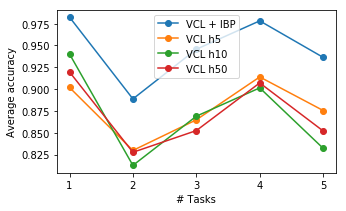

In [89]:
_ibp_acc = np.nanmean(ibp_acc, (0,1))
_vcl_result = np.nanmean(vcl_result, (0,1))
_vcl_result_h5 = np.nanmean(vcl_result_h5, (0,1))
_vcl_result_h50 = np.nanmean(vcl_result_h50, (0,1))

fig = plt.figure(figsize=(5,3))
ax = plt.gca()
plt.plot(np.arange(len(_ibp_acc))+1, _ibp_acc, label='VCL + IBP', marker='o')
plt.plot(np.arange(len(_vcl_result))+1, _vcl_result_h5, label='VCL h5', marker='o')
plt.plot(np.arange(len(_vcl_result))+1, _vcl_result, label='VCL h10', marker='o')
plt.plot(np.arange(len(_vcl_result))+1, _vcl_result_h50, label='VCL h50', marker='o')
ax.set_xticks(range(1, len(_ibp_acc)+1))
ax.set_ylabel('Average accuracy')
ax.set_xlabel('# Tasks')
ax.legend()
fig.show()

# Background images MNIST

In [94]:
#split_mnist_res5_split_background.pkl
with open('ddm/results/split_mnist_res5_split_background.pkl', 'rb') as input_file:
    d = pickle.load(input_file)
d.keys()

dict_keys(['vcl_ibp', 'vcl_h10', 'vcl_h5', 'vcl_h50'])

In [95]:
ibp_acc = d['vcl_ibp'] # 5, 5, 5
vcl_result = d['vcl_h10']
vcl_result_h5 = d['vcl_h5']
vcl_result_h50 = d['vcl_h50']
_ibp_acc = np.mean(ibp_acc, 0)
_vcl_result = np.mean(vcl_result, 0)
_vcl_result_h5 = np.mean(vcl_result_h5, 0)
_vcl_result_h50 = np.mean(vcl_result_h50, 0)

/Users/samuelKessler/anaconda3/envs/py36/lib/python3.6/site-packages/matplotlib/figure.py:448: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


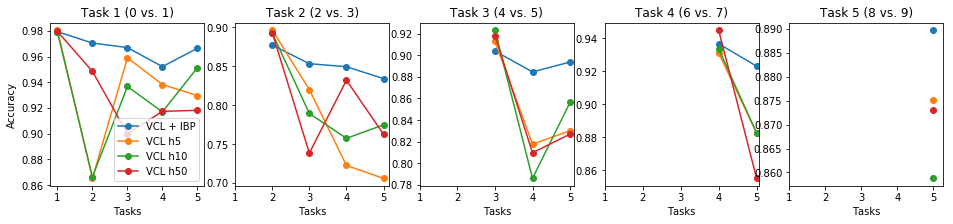

In [96]:
titles = {0: "Task 1 (0 vs. 1)",
          1: "Task 2 (2 vs. 3)",
          2: "Task 3 (4 vs. 5)",
          3: "Task 4 (6 vs. 7)",
          4: "Task 5 (8 vs. 9)"}
no_tasks=5
fig, ax = plt.subplots(1, 5, figsize=(16, 3))
for i in range(no_tasks):
    ax[i].plot(np.arange(len(ibp_acc[:, i]))+1, _ibp_acc[:, i], label='VCL + IBP', marker='o')
    ax[i].plot(np.arange(len(vcl_result_h5[:, i]))+1, _vcl_result_h5[:, i], label='VCL h5', marker='o')
    ax[i].plot(np.arange(len(vcl_result[:, i]))+1, _vcl_result[:, i], label='VCL h10', marker='o')
    ax[i].plot(np.arange(len(vcl_result_h50[:, i]))+1, _vcl_result_h50[:, i], label='VCL h50', marker='o')
    ax[i].set_title(titles[i])
    ax[i].set_xticks(range(1, len(vcl_result[:,i])+1))
    ax[i].set_xlabel('Tasks')
    if i == 0:
        ax[i].legend()
        ax[i].set_ylabel('Accuracy')
fig.show()

/Users/samuelKessler/anaconda3/envs/py36/lib/python3.6/site-packages/matplotlib/figure.py:448: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


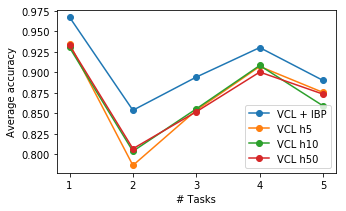

In [97]:
_ibp_acc = np.nanmean(ibp_acc, (0,1))
_vcl_result = np.nanmean(vcl_result, (0,1))
_vcl_result_h5 = np.nanmean(vcl_result_h5, (0,1))
_vcl_result_h50 = np.nanmean(vcl_result_h50, (0,1))

fig = plt.figure(figsize=(5,3))
ax = plt.gca()
plt.plot(np.arange(len(_ibp_acc))+1, _ibp_acc, label='VCL + IBP', marker='o')
plt.plot(np.arange(len(_vcl_result))+1, _vcl_result_h5, label='VCL h5', marker='o')
plt.plot(np.arange(len(_vcl_result))+1, _vcl_result, label='VCL h10', marker='o')
plt.plot(np.arange(len(_vcl_result))+1, _vcl_result_h50, label='VCL h50', marker='o')
ax.set_xticks(range(1, len(_ibp_acc)+1))
ax.set_ylabel('Average accuracy')
ax.set_xlabel('# Tasks')
ax.legend()
fig.show()

# BO results

In [19]:
with open('res.pkl', 'rb') as f:
    a = pickle.load(f)

In [20]:
a.keys()

dict_keys(['vcl+ibp', 'vcl'])

In [21]:
ibp_acc = a['vcl+ibp']
vcl_acc = a['vcl']

In [22]:
ibp_acc

array([[0.99905437,        nan,        nan,        nan,        nan],
       [0.99810875, 0.97306562,        nan,        nan,        nan],
       [0.9858156 , 0.94025465, 0.99199573,        nan,        nan],
       [0.93806147, 0.91968658, 0.98345784, 0.9939577 ,        nan],
       [0.92434988, 0.88883448, 0.97652081, 0.97079557, 0.97680282]])

In [23]:
vcl_acc

array([[0.99952719,        nan,        nan,        nan,        nan],
       [0.99196217, 0.99216454,        nan,        nan,        nan],
       [0.87990544, 0.9906954 , 0.99946638,        nan,        nan],
       [0.8893617 , 0.97796278, 0.99199573, 0.99748238,        nan],
       [0.92245863, 0.79187071, 0.98078975, 0.97180262, 0.98638427]])

/home/skessler/anaconda2/envs/py36/lib/python3.6/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


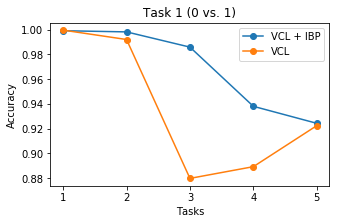

In [26]:
fig = plt.figure(figsize=(5,3))
ax = plt.gca()
plt.plot(np.arange(len(ibp_acc[:,0]))+1, ibp_acc[:,0], label='VCL + IBP', marker='o')
plt.plot(np.arange(len(vcl_acc[:,0]))+1, vcl_acc[:,0], label='VCL', marker='o')
ax.set_title("Task 1 (0 vs. 1)")
ax.set_xticks(range(1, len(vcl_acc[:,0])+1))
ax.set_ylabel('Accuracy')
ax.set_xlabel('Tasks')
ax.legend()
fig.show()

/home/skessler/anaconda2/envs/py36/lib/python3.6/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


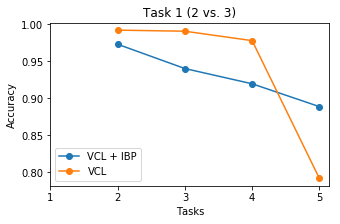

In [27]:
fig = plt.figure(figsize=(5,3))
ax = plt.gca()
plt.plot(np.arange(len(ibp_acc[:,1]))+1, ibp_acc[:,1], label='VCL + IBP', marker='o')
plt.plot(np.arange(len(vcl_acc[:,1]))+1, vcl_acc[:,1], label='VCL', marker='o')
ax.set_title("Task 1 (2 vs. 3)")
ax.set_xticks(range(1, len(vcl_acc[:,1])+1))
ax.set_ylabel('Accuracy')
ax.set_xlabel('Tasks')
ax.legend()
fig.show()

/home/skessler/anaconda2/envs/py36/lib/python3.6/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


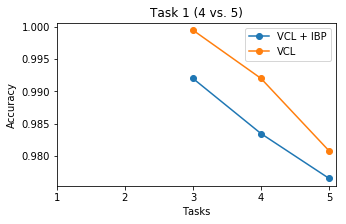

In [28]:
fig = plt.figure(figsize=(5,3))
ax = plt.gca()
plt.plot(np.arange(len(ibp_acc[:,2]))+1, ibp_acc[:,2], label='VCL + IBP', marker='o')
plt.plot(np.arange(len(vcl_acc[:,2]))+1, vcl_acc[:,2], label='VCL', marker='o')
ax.set_title("Task 1 (4 vs. 5)")
ax.set_xticks(range(1, len(vcl_acc[:,2])+1))
ax.set_ylabel('Accuracy')
ax.set_xlabel('Tasks')
ax.legend()
fig.show()

/home/skessler/anaconda2/envs/py36/lib/python3.6/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


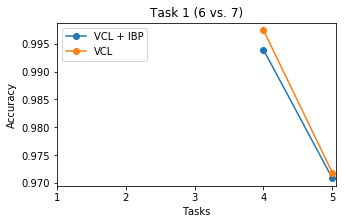

In [29]:
fig = plt.figure(figsize=(5,3))
ax = plt.gca()
plt.plot(np.arange(len(ibp_acc[:,3]))+1, ibp_acc[:,3], label='VCL + IBP', marker='o')
plt.plot(np.arange(len(vcl_acc[:,3]))+1, vcl_acc[:,3], label='VCL', marker='o')
ax.set_title("Task 1 (6 vs. 7)")
ax.set_xticks(range(1, len(vcl_acc[:,3])+1))
ax.set_ylabel('Accuracy')
ax.set_xlabel('Tasks')
ax.legend()
fig.show()

/home/skessler/anaconda2/envs/py36/lib/python3.6/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


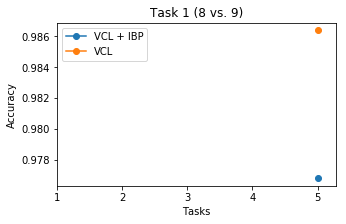

In [30]:
fig = plt.figure(figsize=(5,3))
ax = plt.gca()
plt.plot(np.arange(len(ibp_acc[:,4]))+1, ibp_acc[:,4], label='VCL + IBP', marker='o')
plt.plot(np.arange(len(vcl_acc[:,4]))+1, vcl_acc[:,4], label='VCL', marker='o')
ax.set_title("Task 1 (8 vs. 9)")
ax.set_xticks(range(1, len(vcl_acc[:,4])+1))
ax.set_ylabel('Accuracy')
ax.set_xlabel('Tasks')
ax.legend()
fig.show()

In [31]:
_ibp_acc = np.nanmean(ibp_acc, 1)
_vcl_result = np.nanmean(vcl_result, 1)

In [32]:
_vcl_result

array([0.99952719, 0.99206336, 0.95668907, 0.96420065, 0.9306612 ])

/home/skessler/anaconda2/envs/py36/lib/python3.6/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


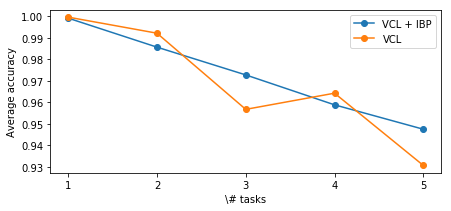

In [33]:
fig = plt.figure(figsize=(7,3))
ax = plt.gca()
plt.plot(np.arange(len(_ibp_acc))+1, _ibp_acc, label='VCL + IBP', marker='o')
plt.plot(np.arange(len(_vcl_result))+1, _vcl_result, label='VCL', marker='o')
ax.set_xticks(range(1, len(_ibp_acc)+1))
ax.set_ylabel('Average accuracy')
ax.set_xlabel('\# tasks')
ax.legend()
fig.show()